# Init

## Imports

In [212]:
# Python modules
import itertools
import time

# Data management
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pylab as plt
import seaborn as sns
sns.set(style="ticks", font="Source Sans Pro", font_scale=.9, palette="muted")

# Fitting
import scipy.optimize as opt

# Project modules
import luescher_nd.utilities as ut

In [42]:
%load_ext blackcellmagic

## Parameters

Quantities will be expressed in units of [fm]. Energies are converted to inverse fermi using $\hbar c = 197.326$ MeV/fm.

In [2]:
HBARC = 197.326 # MeV / fm
M_NUCLEON = (938.27 + 939.57) / 2 / HBARC # in fm^{-1}

# 1-D

## Functions

In [63]:
def s1(x):
    """S1(x) as defined in equation (34) of your notes (for also negative x).
    """
    s1_pos = lambda x: -np.pi / np.tan(np.pi * np.sqrt(x)) / np.sqrt(x)
    s1_neg = lambda x: +np.pi / np.tanh(np.pi * np.sqrt(-x)) / np.sqrt(-x)
    res = []
    for el in x:
        if abs(el) < 1.e-10:
            res.append(np.nan)
        elif el > 0:
            res.append(s1_pos(el))
        else:
            res.append(s1_neg(el))
            
    return np.array(res)

## Plotting

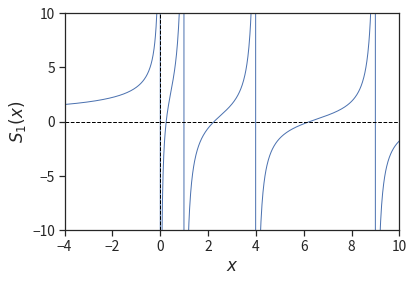

In [188]:
x = np.linspace(-4, 10, 1000)

fig_zeta_1d, ax = plt.subplots()

ax.plot(x, s1(x), "-", lw=1)

ax.set_ylim(-10, 10)
ax.set_xlim(x.min(), x.max())

ax.axhline(0, ls="--", c="black", lw=1)
ax.axvline(0, ls="--", c="black", lw=1)

ax.set_xlabel("$x$")
ax.set_ylabel("$S_1(x)$")

plt.show(fig_zeta_1d)

$$C_0(\Lambda) = - \frac{2}{m a_0}$$
$$x = \left( \frac{\gamma L}{2 \pi} \right)^2 = \frac{\mu E L^2}{2\pi^2}$$
$$a_0 = \frac{L}{2 \pi^2} S_1(x)$$

In [233]:
L = 20.  # in fm -- fixed for no finite volume differences
c0 = -0.3  # in fm^0 -- fixed to fix energy in continuum

mu = M_NUCLEON / 2
gamma0 = -c0 * mu
E0 = -gamma0 ** 2 / 2 / mu  # in fm^{-1} -- fixed

epsilons = np.array([1.0, 0.5 , 0.1])

c_lats = c0 * np.sqrt(1 + gamma0 ** 2 * epsilons ** 2 / 4)
a0_analytic = -2 / (mu * 2) / c0

In [234]:
def energy2x(energy, mass, L):
    """
    """
    x_ = np.sqrt(np.abs(energy) * 2 * mass) * L / 2 / np.pi
    x_ *= x_
    
    return np.where(energy > 0, x_, -x_)

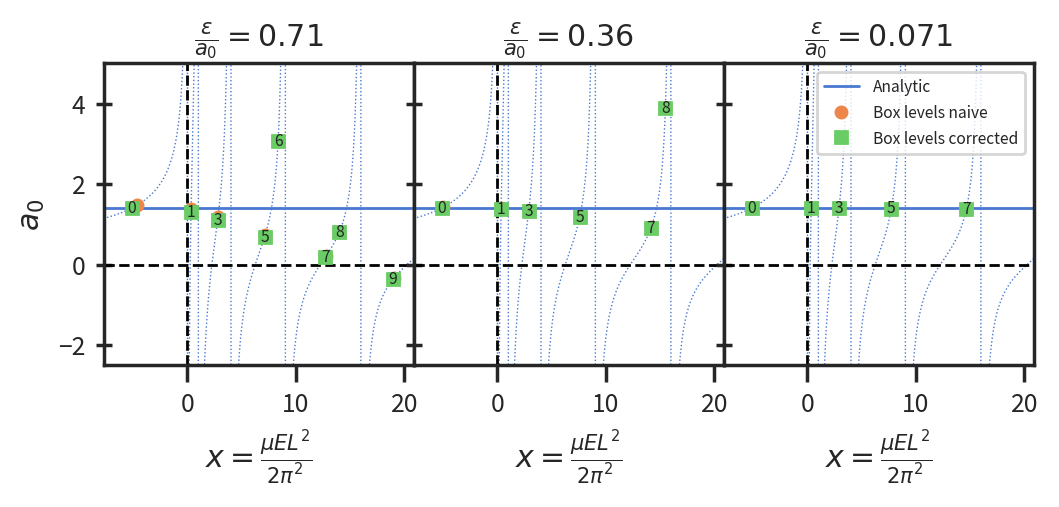

In [266]:
fig, axs = plt.subplots(
    dpi=200, figsize=(6, 2), ncols=len(epsilons), sharey=True, sharex=True
)

y_min = -2.5
y_max = 5

for n_ax, (ax, (c_lat, epsilon)) in enumerate(zip(axs, zip(c_lats, epsilons))):

    n1d_max = int(L / epsilon)

    solver = ut.Solver(n1d_max=n1d_max, ndim_max=1, lattice_spacing=epsilon)

    energies_naive = solver.get_energies(c0, n_energies=n1d_max - 1)
    energies_naive = np.array(energies_naive)

    energies_correct = solver.get_energies(c_lat, n_energies=n1d_max - 1)
    energies_correct = np.array(energies_correct)

    x0_naive = energy2x(energies_naive[:10], mu, L)
    x0_correct = energy2x(energies_correct[:10], mu, L)

    x = np.linspace(x0.min() * 1.5, x0.max() * 1.1, 1000)

    ax.plot(x, s1(x) * L / 2 / np.pi ** 2, ":", lw=.5)

    ax.axhline(0, ls="--", c="black", lw=1)
    ax.axvline(0, ls="--", c="black", lw=1)
    ax.axhline(a0_analytic, lw=1, label="Analytic")

    y_naive = s1(x0_naive) * L / 2 / np.pi ** 2
    ax.plot(x0_naive, y_naive, "o", ms=4, label="Box levels naive")

    y_correct = s1(x0_correct) * L / 2 / np.pi ** 2
    ax.plot(x0_correct, y_correct, "s", ms=4, label="Box levels corrected")
    for n, xy in enumerate(zip(x0_correct, y_correct)):
        if xy[1] < y_max and xy[1] > y_min and xy[0] < x.max() and xy[0] > x.min():
            ax.text(
                xy[0], xy[1], n, fontdict={"size": "xx-small"}, ha="center", va="center"
            )

    ax.set_ylim(y_min, y_max)
    ax.set_xlim(x.min(), x.max())

    ax.set_title(r"$\frac{\epsilon}{a_0} = "+ f" {epsilon/a0_analytic:1.2}$")
    
    ax.tick_params(axis="y",direction="inout")
    ax.set_xlabel(r"$x = \frac{\mu E L^2}{2\pi^2}$")
    if n_ax == 0:
        ax.set_ylabel("$a_0$")

    if n_ax == len(axs) - 1:
        ax.legend(loc="best", fontsize="xx-small")

plt.subplots_adjust(wspace=0.0)
plt.show(fig)

Note that each second state seemingly diverges. This is (probably) the case because each second state is parity odd and thus does not see the delta function. In this case, the contact interaction is effectively zero and for 1-d the scattering lenght diverges to $+\infty$.

In [267]:
fig.savefig("1d-luescher-levels.pdf", bbox_inches="tight")

## 2-D

In [277]:
def zeta2(x, L, Lambda):
    """
    """
    lp = int(Lambda*L/2/np.pi)
    res = - 2*np.pi * np.log(lp)
    for nxi in itertools.product(*[range(-lp, lp)]*2):
        res += 1/((np.sum(np.array(nxi)**2))-x)
        
    return x
        
        
    

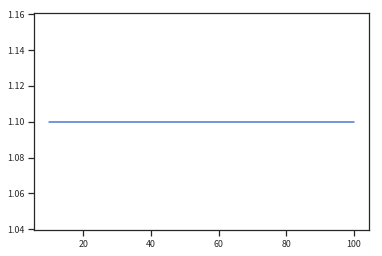

In [278]:
Lambda = np.linspace(10, 1.e2, 10)
plt.plot(Lambda, [zeta2(1.1, 20, l) for l in Lambda])

In [14]:
from luescher_nd.zeta import zeta2

In [16]:
zeta2([1.1, 2.1], 10)

array([-37.52679095, -43.17331269])